In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from lmmnn.layers import NLL
from lmmnn.callbacks import EarlyStoppingWithSigmasConvergence

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Layer, Input, Dropout, Embedding, Reshape, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, Callback
import tensorflow.keras.backend as K

import tensorflow as tf

In [2]:
# Note: pa_final.csv is the result of an ETL process described in Pierce et. al. (2020), see our paper
# after downloading the UKB relevant data.
ukb = pd.read_csv('C:/Users/gsimchoni/ukb/pa_final.csv')
ukb.drop(['center', 'job_orig', 'center_orig'], axis=1, inplace=True)

In [3]:
ukb.head()

gender   enmo  job  heavy_work  walking_work  sedentary_work      mvpa  \
0       0  27.17    0     0.00000      0.000000        5.957686  4.824879   
1       1  20.09    1     0.00000      4.330733        5.420535  2.772589   
2       1  35.82    2     0.00000      0.000000        4.928288  3.945734   
3       0  22.82    3     0.00000      0.000000        0.000000  4.242354   
4       0  31.54    4     3.99951      0.000000        5.085831  3.433987   

   walking_pleasure  strenuous_sport  other_act  ...  getting_cycle  \
0          2.983153         0.000000   2.460809  ...              0   
1          1.613003         0.000000   0.000000  ...              0   
2          2.983153         2.040756   1.613003  ...              0   
3          0.000000         0.000000   0.000000  ...              0   
4          0.000000         0.000000   0.000000  ...              0   

   getting_other  getting_transport  getting_walk  commuting_cycle  \
0              0                  0             0                0   
1              0                  0             0                0   
2              0                  0             0                0   
3              0                  0             1                0   
4              0                  0             0                0   

   commuting_other  commuting_transport  commuting_walk  sleep      bmi  
0                0                    0               1      7  23.4959  
1                1                    0               0      7  31.8077  
2                0                    0               0      7  24.6918  
3                1                    0               0      7  19.7777  
4                0                    0               1      6  33.7768  

[5 rows x 24 columns]

In [34]:
ukb = ukb[ukb['enmo'] < 80]
ukb.index = range(ukb.shape[0])

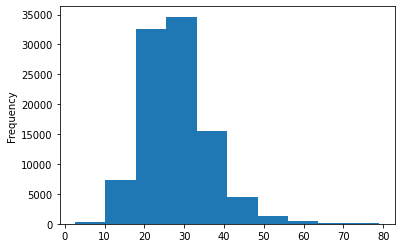

In [6]:
ukb['enmo'].plot(kind='hist')
plt.show()

In [7]:
n_cats = len(ukb['job'].unique())

In [8]:
ukb.shape

(96629, 24)

In [17]:
def calc_b_hat(X_train, y_train, y_pred_tr, n_cats, sig2e, sig2b, Z_name):
    b_hat = []
    for i in range(n_cats):
        i_vec = X_train[Z_name] == i
        n_i = i_vec.sum()
        if n_i > 0:
            y_bar_i = y_train[i_vec].mean()
            y_pred_i = y_pred_tr[i_vec].mean()
            # BP(b_i) = (n_i * sig2b / (sig2a + n_i * sig2b)) * (y_bar_i - y_pred_bar_i)
            b_i = n_i * sig2b * (y_bar_i - y_pred_i) / (sig2e + n_i * sig2b)
        else:
            b_i = 0
        b_hat.append(b_i)
    return np.array(b_hat)

def process_one_hot_encoding(X_train, X_test, RE_col):
    X_train_ohe = pd.concat([X_train[x_cols], pd.get_dummies(X_train[RE_col])], axis=1)
    X_test_ohe = pd.concat([X_test[x_cols], pd.get_dummies(X_test[RE_col])], axis=1)
    X_test_cols_in_train = set(X_test_ohe.columns).intersection(X_train_ohe.columns)
    X_train_cols_not_in_test = set(X_train_ohe.columns).difference(X_test_ohe.columns)
    X_test_comp = pd.DataFrame(np.zeros((X_test.shape[0], len(X_train_cols_not_in_test))),
                               columns=X_train_cols_not_in_test, dtype=np.uint8, index=X_test.index)
    X_test_ohe_comp = pd.concat([X_test_ohe[X_test_cols_in_train], X_test_comp], axis=1)
    X_test_ohe_comp = X_test_ohe_comp[X_train_ohe.columns]
    return X_train_ohe, X_test_ohe_comp

def add_shallow_layers_sequential(model, input_dim):
    model.add(Dense(10, input_dim=input_dim))

def add_deep_layers_sequential(model, input_dim):
    model.add(Dense(10, input_dim=input_dim, activation='relu'))
    model.add(Dense(5, activation='relu'))

def add_shallow_layers_functional(X_input):
    return Dense(10)(X_input)

def add_deep_layers_functional(X_input):
    hidden1 = Dense(10, activation='relu')(X_input)
    out_hidden = Dense(5, activation='relu')(hidden1)
    return out_hidden

def reg_nn_ohe_or_ignore(X_train, X_test, y_train, y_test, n_cats, batch_size, epochs, patience, deep=False, ignore_RE=False):
    if ignore_RE:
        X_train, X_test = X_train[x_cols], X_test[x_cols]
    else:
        X_train, X_test = process_one_hot_encoding(X_train, X_test, 'job')
    
    model = Sequential()
    if deep:
        add_deep_layers_sequential(model, X_train.shape[1])
    else:
        add_shallow_layers_sequential(model, X_train.shape[1])
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam')

    callbacks = [EarlyStopping(monitor='val_loss', patience=epochs if patience is None else patience)]
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                        validation_split=0.1, callbacks=callbacks, verbose=0)
    y_pred = model.predict(X_test).reshape(X_test.shape[0])
    return y_pred, (None, None)

def reg_nn_lmm(X_train, X_test, y_train, y_test, n_cats, batch_size, epochs, patience, deep=False):
    X_input = Input(shape=(X_train[x_cols].shape[1],))
    y_true_input = Input(shape=(1,))
    Z_input = Input(shape=(1,), dtype=tf.int64)
    if deep:
        out_hidden = add_deep_layers_functional(X_input)
    else:
        out_hidden = add_shallow_layers_functional(X_input)
    y_pred_output = Dense(1)(out_hidden)
    nll = NLL(1.0, 1.0)(y_true_input, y_pred_output, Z_input)
    model = Model(inputs=[X_input, y_true_input, Z_input], outputs=nll)

    model.compile(optimizer= 'adam')
    
    patience = epochs if patience is None else patience
    callbacks = [EarlyStoppingWithSigmasConvergence(patience=patience)]
    history = model.fit([X_train[x_cols], y_train, X_train['job']], None,
                        batch_size=batch_size, epochs=epochs, validation_split=0.1,
                        callbacks=callbacks, verbose=0)
    
    sig2e_est, sig2b_est = model.layers[-1].get_vars()
    y_pred_tr = model.predict([X_train[x_cols], y_train, X_train['job']]).reshape(X_train.shape[0])
    b_hat = calc_b_hat(X_train, y_train, y_pred_tr, n_cats, sig2e_est, sig2b_est, 'job')
    dummy_y_test = np.random.normal(size=y_test.shape)
    y_pred = model.predict([X_test[x_cols], dummy_y_test, X_test['job']]).reshape(X_test.shape[0]) + b_hat[X_test['job']]
    return y_pred, (sig2e_est, sig2b_est)

def reg_nn_embed(X_train, X_test, y_train, y_test, n_cats, batch_size, epochs, patience, deep=False):
    embed_dim = 10
    
    X_input = Input(shape=(X_train[x_cols].shape[1],))
    Z_input = Input(shape=(1,))
    embed = Embedding(n_cats, embed_dim, input_length = 1)(Z_input)
    embed = Reshape(target_shape = (embed_dim,))(embed)
    concat = Concatenate()([X_input, embed])
    if deep:
        out_hidden = add_deep_layers_functional(concat)
    else:
        out_hidden = add_shallow_layers_functional(concat)
    output = Dense(1)(out_hidden)
    model = Model(inputs=[X_input, Z_input], outputs=output)

    model.compile(loss='mse', optimizer='adam')

    callbacks = [EarlyStopping(monitor='val_loss', patience=epochs if patience is None else patience)]
    history = model.fit([X_train[x_cols], X_train['job']], y_train,
                        batch_size=batch_size, epochs=epochs, validation_split=0.1,
                        callbacks=callbacks, verbose=0)
    y_pred = model.predict([X_test[x_cols], X_test['job']]).reshape(X_test.shape[0])
    return y_pred, (None, None)

def reg_nn(X_train, X_test, y_train, y_test, n_cats, batch=30, epochs=2000, patience=10, reg_type='ohe', deep=False):    
    if reg_type == 'ohe':
        y_pred, sigmas = reg_nn_ohe_or_ignore(X_train, X_test, y_train, y_test, n_cats, batch, epochs, patience, deep)
    elif reg_type == 'lmm':
        y_pred, sigmas = reg_nn_lmm(X_train, X_test, y_train, y_test, n_cats, batch, epochs, patience, deep)
    elif reg_type == 'ignore':
        y_pred, sigmas = reg_nn_ohe_or_ignore(X_train, X_test, y_train, y_test, n_cats, batch, epochs, patience, deep, ignore_RE=True)
    else:
        y_pred, sigmas = reg_nn_embed(X_train, X_test, y_train, y_test, n_cats, batch, epochs, patience, deep)
    mse = np.mean((y_pred - y_test)**2)
    return mse, sigmas

In [35]:
res = pd.DataFrame(columns=['experiment', 'exp_type', 'deep', 'mse', 'sigma_e_est', 'sigma_b_est'])
counter = 0

def iterate_reg_types(X_train, X_test, y_train, y_test, deep):
    global counter
    mse_lm, _ = reg_nn(X_train, X_test, y_train, y_test, n_cats, reg_type='ohe', deep=deep)
    print(' finished lm deep=%s, mse: %.2f' % (deep, mse_lm))
    mse_lmm, sigmas = reg_nn(X_train, X_test, y_train, y_test, n_cats, reg_type='lmm', deep=deep)
    print(' finished lmm deep=%s, mse: %.2f' % (deep, mse_lmm))
    mse_ig, _ = reg_nn(X_train, X_test, y_train, y_test, n_cats, reg_type='ignore', deep=deep)
    print(' finished ignore deep=%s, mse: %.2f' % (deep, mse_ig))
    mse_em, _ = reg_nn(X_train, X_test, y_train, y_test, n_cats, reg_type='embed', deep=deep)
    print(' finished embed deep=%s, mse: %.2f' % (deep, mse_em))
    mse_dec = 100 * (mse_lmm - mse_lm) / mse_lm
    res.loc[counter + 0] = [i, 'lm', deep, mse_lm, np.nan, np.nan]
    res.loc[counter + 1] = [i, 'lmm', deep, mse_lmm, sigmas[0], sigmas[1]]
    res.loc[counter + 2] = [i, 'ignore', deep, mse_ig, np.nan, np.nan]
    res.loc[counter + 3] = [i, 'embed', deep, mse_em, np.nan, np.nan]
    counter += 4
    print('iteration %d, deep=%s, mse change from mse_lm: %.2f%%' % (i, deep, mse_dec))   

kf = KFold(n_splits=5)
X, y = ukb.drop('enmo', axis=1), ukb['enmo']
x_cols = [col for col in X.columns if col != 'job']

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    print('iteration %d' % i)
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y[train_index], y[test_index]
    scaler = StandardScaler()
    y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).reshape(X_train.shape[0])
    y_test = scaler.transform(y_test.values.reshape(-1, 1)).reshape(X_test.shape[0])
    iterate_reg_types(X_train, X_test, y_train, y_test, True)

iteration 0
 finished lm deep=True, mse: 0.80
 finished lmm deep=True, mse: 0.79
 finished ignore deep=True, mse: 0.80
 finished embed deep=True, mse: 0.80
iteration 0, deep=True, mse change from mse_lm: -0.45%
iteration 1
 finished lm deep=True, mse: 0.85
 finished lmm deep=True, mse: 0.84
 finished ignore deep=True, mse: 0.84
 finished embed deep=True, mse: 0.86
iteration 1, deep=True, mse change from mse_lm: -1.34%
iteration 2
 finished lm deep=True, mse: 0.80
 finished lmm deep=True, mse: 0.80
 finished ignore deep=True, mse: 0.80
 finished embed deep=True, mse: 0.80
iteration 2, deep=True, mse change from mse_lm: -0.94%
iteration 3
 finished lm deep=True, mse: 0.81
 finished lmm deep=True, mse: 0.81
 finished ignore deep=True, mse: 0.81
 finished embed deep=True, mse: 0.81
iteration 3, deep=True, mse change from mse_lm: -0.35%
iteration 4
 finished lm deep=True, mse: 0.82
 finished lmm deep=True, mse: 0.80
 finished ignore deep=True, mse: 0.81
 finished embed deep=True, mse: 0.82


In [36]:
res

experiment exp_type  deep       mse  sigma_e_est  sigma_b_est
0           0       lm  True  0.796427          NaN          NaN
1           0      lmm  True  0.792857     0.802984     0.026488
2           0   ignore  True  0.796482          NaN          NaN
3           0    embed  True  0.799779          NaN          NaN
4           1       lm  True  0.850871          NaN          NaN
5           1      lmm  True  0.839481     0.958734     0.053938
6           1   ignore  True  0.843228          NaN          NaN
7           1    embed  True  0.855721          NaN          NaN
8           2       lm  True  0.804002          NaN          NaN
9           2      lmm  True  0.796409     0.814193     0.016641
10          2   ignore  True  0.798040          NaN          NaN
11          2    embed  True  0.803481          NaN          NaN
12          3       lm  True  0.812773          NaN          NaN
13          3      lmm  True  0.809889     0.823830     0.008857
14          3   ignore  True  0.812973          NaN          NaN
15          3    embed  True  0.811329          NaN          NaN
16          4       lm  True  0.815863          NaN          NaN
17          4      lmm  True  0.804275     0.802134     0.006731
18          4   ignore  True  0.808503          NaN          NaN
19          4    embed  True  0.815544          NaN          NaN

In [37]:
res.to_csv('../results/res_ukb_pa.csv')